# TP Optimisation II:  A simple neural network 

### Nom(s): Zheng
### Prénom(s): Steven
### Groupe: B2

## Useful packages

In [35]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Loading of the train and test data

In [36]:
#
# Load train data
#
Xtrain = np.load('train-images.npy')
Xtrain = np.array([x.ravel()/255 for x in Xtrain])
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
Ytrain = np.load('train-labels.npy')
targets_train = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytrain:
    v      = np.zeros((10,1))
    v[lab] = 1
    targets_train+=[np.array(v)]

#
# Load test data
#
Xtest        = np.load('t10k-images.npy')
Xtest        = np.array([x.ravel()/255 for x in Xtest])
Xtest        = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
Ytest        = np.load('t10k-labels.npy')
targets_test = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytest:
    v = np.zeros((10,1))
    v[lab]=1
    targets_test+=[np.array(v)]
#
# Outputs
#
print('There are ',Xtrain.shape[0],'images in the train set')
print('There are ',Xtest.shape[0],'images in the test set')

There are  60000 images in the train set
There are  10000 images in the test set


## Definition of the activation function

 The activation function defines the output of a node given a set of inputs. We use the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> function defined by
 
 $$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad  s.t. \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [37]:
#
# Nonlinear activation function
#
def softmax(x,alpha):
    """
    Softmax unit activation function 
    x    : Numpy array
    alpha: scalar
    """ 
    #
    # Softmax function
    value = np.exp(alpha+x)/np.sum(np.exp(alpha+x),axis=0)
    #
    
    return value

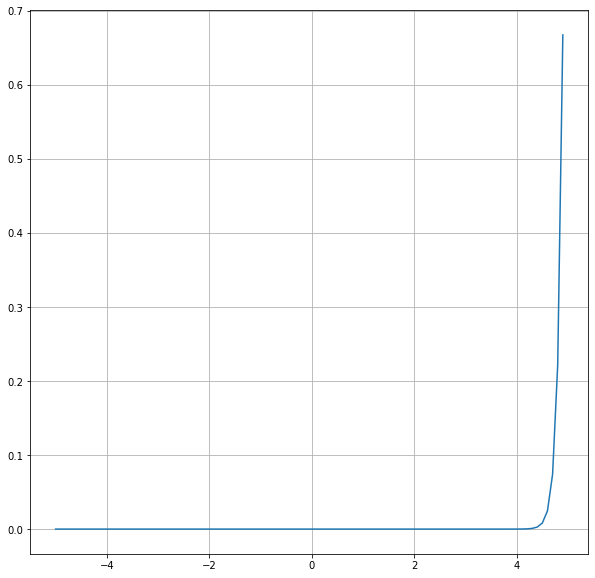

In [38]:
#
# Example of a plot of the activation function
#
t     = np.arange(-5,5,0.1)
alpha = np.arange(-50,50,1)
plt.figure(figsize=(10,10))
plt.plot(t,softmax(t,alpha))
plt.grid(True)
plt.show()

## Definition of a simple neural network

We use a one-layer fully-connected neural network with the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function.


In [39]:
def NN(x,W):
    """
    # One-layer fully connected neural network
    # x: image, i.e. 784x1 vector (28x28)
    # W: weight matrices of shape 10x784   
    """
    #
    # Size of the matrix W
    #
    n,m = np.shape(W)
    pred = softmax(W@x,np.zeros((n,1)))
    #
    
    return pred

## Definition of the loss function

The loss function is the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross-entropy</a> defined by 

$J(W)=-\sum_{i=1}^N p_i \log(q_i(W)),$ where $N$ is the number of classes, $(p_i)_{i=1:N}$ are the probabilities of  a data from the training set to belong to a class (0 or 1 because the labels are known), and $(q_i(W))_{i=1:N}$ are the predicted probabilities from the model

$$\forall i=1:N, \quad q_i(W)=[\sigma_{\alpha}(Wx)]_i.$$

In [40]:
#
# Loss function = Cross-entropy
#
def cross_entropy(pred,target,x):
    """
    pred:   predicted probabilities (q(W))
    target: probabilities (p)
    x:      image 
    """ 
    #
    # TO DO: return ce (cross_entropy)
    #
    ce = -np.sum(target*np.log(pred))
    #
    # gradient of the cross-entropy
    s = pred
    u    =  np.ones((s.shape[0],1))
    g    = (-u.T.dot(target)*(s.dot(x.T))+target*x.T)
    grad = -g.reshape(x.shape[0]*target.shape[0],1)
    
    return ce,grad
#
# Main function 
#
def f(W,x,target):
    """
    W:      weights
    target: probabilities (p)
    x:      image
    """
    #
    # TO DO: return ce, grad, pred (cross_entropy, gradient, predicted probabilities)
    pred = NN(x,W)
    ce,grad = cross_entropy(pred,target,x)

    #
    
    return ce,grad,pred

In [41]:
#
# Test information on the gradient with calls of f
#

# Define weight matrices
W      = np.random.rand(10,Xtrain.shape[1])
eps    = 1e-8
d      = np.random.rand(10,Xtrain.shape[1])
Wtilde = W+eps*d

# Retrieve the information on the gradients
res    = (f(Wtilde,Xtrain[0],targets_train[0])[0]-f(W,Xtrain[0],targets_train[0])[0])/eps
print(res)

g      = f(W,Xtrain[0],targets_train[0])[1]
print(g.T.dot(d.reshape(7840,1)))

2.9512357890837393
[[2.95123504]]


## Generating batches 

In [42]:
#
# Function to create batches of samples to be used later in the training phase
#
def create_batches(x,bs):
    """
    x : set to be considered (array)
    bs: batch size (scalar)
    """
    batches = []
    ind     = np.arange(x.shape[0])
    random.shuffle(ind)
    nbatch  = ind.shape[0]//bs
    rest    = ind.shape[0]%bs
    
    for n in range(nbatch):
        batches +=[ind[bs*n:bs*(n+1)]]
    
    # Put the remaining elements in a last batch
    if rest !=0:        
        batches += [ind[-rest:]]
        
    return batches

## Training of the neural network

In [43]:
history    = {}
eta        = 1e-5 # learning rate
momentum   = 0.5  # momemtum factor
N_EPOCHS   = 10  
BatchSizes = [10000,1024,256] # try different batch sizes for the analysis

for bs in BatchSizes:
    #
    # Sensitivity to the batch size to be investigated in the analysis
    #
    print('batch size=',bs)
    
    history[bs]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])
    w_old = w
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        
        Batches=create_batches(Xtrain,bs)
       
        
        # boucle sur les batchs créer en fonction de leur taille bs
        for batch in Batches:
            # Loop on the batches
            sum_grad = 0
            ce_train = 0
            train_acc = 0
            
            for i in batch:
                
                # pour chaque indices que l'on trouve dans le
                # lot courant (batch), on ajoute le gradient et la
                # cross-entropy calculés pour le x correspondant de Xtrain
                # et la valeur que l'on souhaite obtenir de targets_train
                # pour pouvoir ensuite les moyenner et faire évoluer le 
                # modèle w 
                
                x = Xtrain[i]
                target = targets_train[i]
                ce,grad,pred = f(w+momentum*(w-w_old),x,target)
                sum_grad += grad
                ce_train += ce
                
                # la précision augmente si la prédiction du
                # modèle vaut la valeur voulue 
                
                prediction = list(pred).index(np.max(pred))
                true = list(target).index(1)
                if prediction==true:
                    train_acc += 1
                    
            history[bs]['train acc'] += [train_acc/batch.shape[0]]
            history[bs]['train loss'] += [ce_train/batch.shape[0]]
            
            # on met à jour la matrice des poids en fonction de la moyenne
            # faite sur les gradients calculés afin de faire évoluer 
            # les poids vers un modèle cohérent avec les données de formation
            # présente dans Xtrain 
            
            sum_grad = sum_grad.reshape(w.shape[0],w.shape[1])
            w_old = w
            w = w-eta*sum_grad+momentum*(w-w_old)
            
                   
        # Test accuracy at the end of each epoch  
        #
        # TO DO
        J_test = 0
        test_acc = 0
        for i in range(Xtest.shape[0]):
            pred = NN(Xtest[i],w)
            ce,grad = cross_entropy(pred,targets_test[i],Xtest[i])
            J_test += ce
            
            if list(pred).index(np.max(pred))==list(targets_test[i]).index(1):
                test_acc += 1
                    
        history[bs]['test acc'] += [test_acc/Xtest.shape[0]]
        history[bs]['test loss'] += [J_test/Xtest.shape[0]]

        #
        
        print('Epoch number :', n+1,'test accuracy:',history[bs]['test acc'][n+1],'test loss',history[bs]['test loss'][n+1])
        

    print('\n')            

batch size= 10000
Epoch number : 1 test accuracy: 0.1689 test loss 2.9565595191915346
Epoch number : 2 test accuracy: 0.2633 test loss 2.409858582835111
Epoch number : 3 test accuracy: 0.3527 test loss 2.0443966574439347
Epoch number : 4 test accuracy: 0.4277 test loss 1.780215528189409
Epoch number : 5 test accuracy: 0.4902 test loss 1.5838169357442389
Epoch number : 6 test accuracy: 0.5373 test loss 1.4343409381825671
Epoch number : 7 test accuracy: 0.5724 test loss 1.3171012349589009
Epoch number : 8 test accuracy: 0.6031 test loss 1.2234859107106602
Epoch number : 9 test accuracy: 0.63 test loss 1.1468530375268342
Epoch number : 10 test accuracy: 0.6516 test loss 1.0830668531468042


batch size= 1024
Epoch number : 1 test accuracy: 0.094 test loss 3.792937937656112
Epoch number : 2 test accuracy: 0.1578 test loss 3.0899666649624833
Epoch number : 3 test accuracy: 0.2265 test loss 2.555714401743885
Epoch number : 4 test accuracy: 0.3127 test loss 2.152732558217401
Epoch number : 5 t

## Plots of the evolution of the loss function

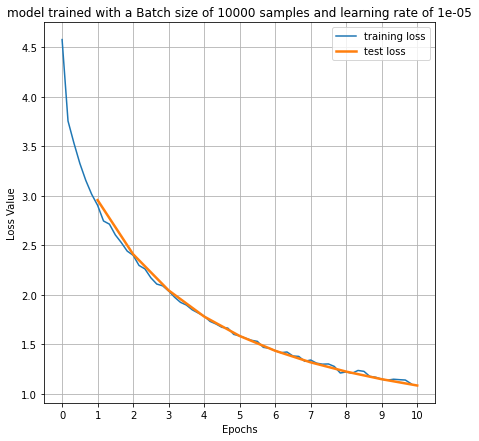

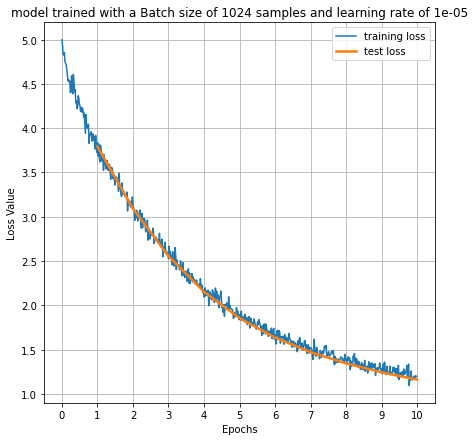

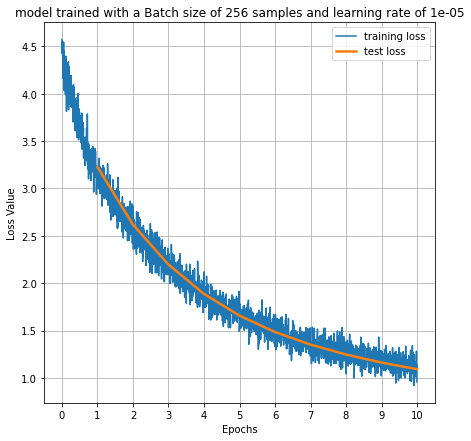

In [44]:
for bs in BatchSizes:
       
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[bs]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.show()

## Plots of the evolution of the accuracy

10000
6


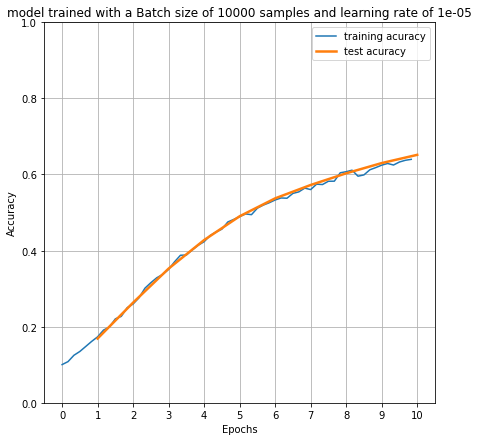

1024
59


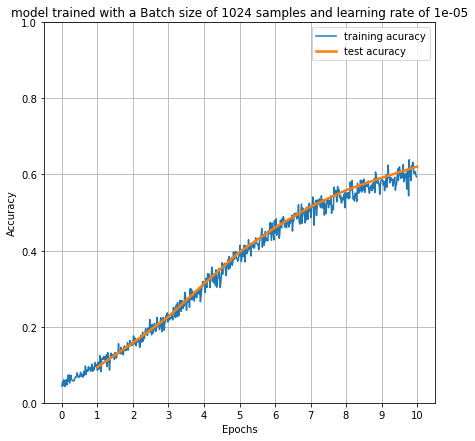

256
235


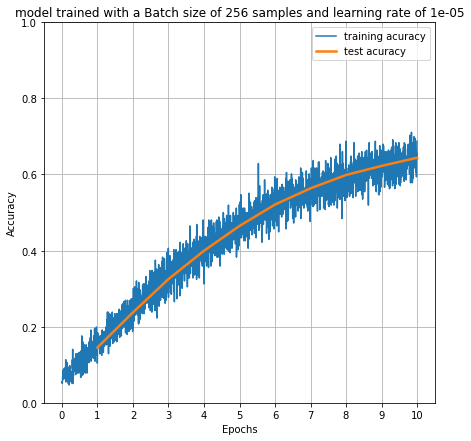

In [45]:
for bs in BatchSizes:
    print(bs)   
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    print(n_batch)
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[bs]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Analysis of the results

Please provide your comments on the sensitivity of the results to the parameters involved in the learning process (batch size, learning rate, momentum).

### Your comments:

## Comments on the sensitivity to the results obtained with the different parameters (batch size, learning rate, momentum factor)
The batch size is the number of samples that are used to update the weights. Larger batch sizes can result in faster convergence during training, but they may also lead to overfitting or suboptimal performance if the model is not able to generalize well to new data. Smaller batch sizes may require more iterations to converge, but they can also provide better generalization and prevent overfitting.

Similarly, the learning rate determines how quickly the model updates its parameters based on the gradient of the loss function. If the learning rate is too high, the model may overshoot the optimal parameters and fail to converge. If the learning rate is too low, the model may converge slowly or get stuck in local minima.

The momentum factor can help accelerate convergence by allowing the model to continue in the same direction as previous updates, which can help the model escape local minima. However, if the momentum factor is too high, the model may overshoot the optimal parameters and fail to converge.
